# Modeling: Multilingual Twitter XLM-roBERTa-base For Sentiment Analysis
*Fine-tuning an XLM-roBERTa model for ISP Sentiment Prediction*

**`Goal:`** Compare the performance of three different models (BERTweet, XLM-roBERTa, and M-BERT) for sentiment analysis. Here, macro-F1 score serves as the key metric of interest


**`Justification:`** Following findings from my [initial sentiment analysis implementation](https://github.com/KoredeAkande/nigerian_isp_sentiment_analysis/tree/main/notebooks/test-version) suggesting that Pidign English might be useful to account for, I look into multilingual models as potential solutions. In particular I select a Twitter XLM-roBERTa model because in addition to incorporating multilingualism, it is also close to the problem domain of Twitter.

### 1. Library Importation

In [1]:
#Visualization packages
import pandas as pd
import numpy as np
import seaborn as sns
#sns.set()
import matplotlib.pyplot as plt

#Modeling and evaluation packages
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

### 2. Loading the data

In [2]:
df = pd.read_csv('../data/processed/sample_encoded_and_cleaned.csv')

In [3]:
df

,ISP_Name,Time,Text,Source,sentiment,label
0,sprectranet,2020-02-04 18:30:35+00:00,my family used my spectranet and they don't wa...,Twitter for Android,Neutral,1
1,sprectranet,2019-06-19 04:59:49,spectranet_ng how can i get the freedom mifi i...,Twitter for iPhone,Neutral,1
2,sprectranet,2020-03-30 07:57:38+00:00,drolufunmilayo iconic_remi spectranet_ng,Twitter for iPhone,Neutral,1
3,sprectranet,2020-12-31 21:07:52+00:00,spectranet_ng your response just proves how ho...,Twitter for Android,Negative,0
4,sprectranet,2020-09-03 23:09:09+00:00,"spectranet is just the worse tbh, i can't even...",Twitter for iPhone,Negative,0
...,...,...,...,...,...,...
372,sprectranet,2019-01-04 14:44:03,spectranet unlimited. value for money,Twitter for iPhone,Positive,2
373,sprectranet,2020-06-17 13:32:28+00:00,from 30th may to date mtn mifi - 10k spectrane...,Twitter for iPhone,Negative,0
374,sprectranet,2020-05-12 16:51:44+00:00,spectranet_ng fritzthejanitor will they help m...,Twitter for iPhone,Neutral,1
375,sprectranet,2019-02-27 18:59:31,thefunkydee spectranet_ng i'm giving spectrane...,Twitter for iPhone,Negative,0


### 3. Split data into training & test set

**Observing the true distribution of the data**

In [4]:
df.label.value_counts(normalize=True)

0    0.572944
1    0.347480
2    0.079576
Name: label, dtype: float64

Seeing as the dataset is highly imbalanced, I perform a **stratified train-test split**:

In [5]:
#Split the data 80:20 and ensure same proportion of classes as original data 
#Note: The below gets the indices of the tweets for the training and test set
X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                    df.label.values, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df.label.values)

In [6]:
#Note which tweets were split into the training and test sets so we can see the division
df.loc[X_train, 'split_group'] = 'training_set'
df.loc[X_test, 'split_group'] = 'test_set'

In [7]:
df.groupby(['sentiment', 'label', 'split_group'])[['Text']].count().sort_values('label')

Text
sentiment label split_group       
Negative  0     test_set        44
                training_set   172
Neutral   1     test_set        26
                training_set   105
Positive  2     test_set         6
                training_set    24

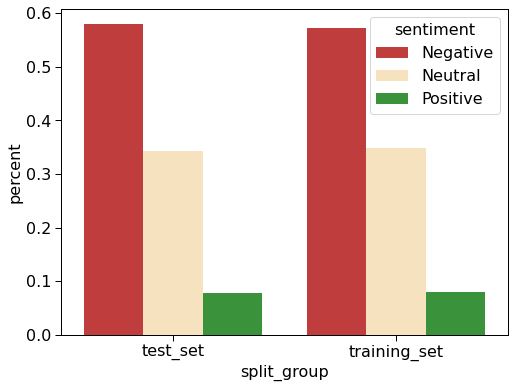

In [8]:
#Plot the proportion of each sentiment class in the training and test sets
#-to confirm the distribution is the same in both sets
with plt.style.context(['notebook','no-latex']):
    sns.barplot(x='split_group', 
                y='percent', 
                hue='sentiment', 
                palette = ['tab:red','moccasin','tab:green'],
                data=df.groupby(['split_group'])['sentiment'].value_counts(normalize=True).\
                                                                         rename('percent').\
                                                                         reset_index())
    plt.show()

### 4. Split training set into training set and validation set

In [9]:
#Split the training set 75:25 using stratified sampling 
#Note: The below gets the indices of the tweets for the training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=1, 
                                                  stratify=y_train)

In [10]:
#Note which tweets were split into the training and validation sets so we can see the division
df.loc[X_train, 'split_group'] = 'training_set'
df.loc[X_val, 'split_group'] = 'validation_set'

In [11]:
df.groupby(['sentiment', 'label', 'split_group'])[['Text']].count().sort_values('label')

Text
sentiment label split_group         
Negative  0     test_set          44
                training_set     129
                validation_set    43
Neutral   1     test_set          26
                training_set      78
                validation_set    27
Positive  2     test_set           6
                training_set      18
                validation_set     6

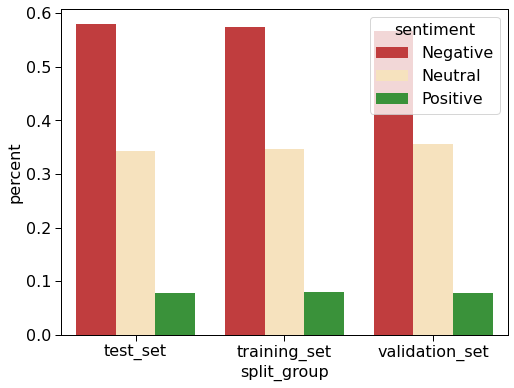

In [12]:
#Plot the proportion of each sentiment class in the training and test sets
#-to confirm the distribution is the same in both sets
with plt.style.context(['notebook','no-latex']):
    sns.barplot(x='split_group', 
                y='percent', 
                hue='sentiment', 
                palette = ['tab:red','moccasin','tab:green'],
                data=df.groupby(['split_group'])['sentiment'].value_counts(normalize=True).\
                                                                         rename('percent').\
                                                                         reset_index())
    plt.show()

In [13]:
df.groupby('split_group')['Text'].count()

split_group
test_set           76
training_set      225
validation_set     76
Name: Text, dtype: int64

### 5. Modeling: XLM roBERTa

In [14]:
#Load the XLMR-roberta tokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")

class Generate_PyTorch_Dataset(torch.utils.data.Dataset):
    
    """
    
    Class to encode a dataset for modeling using the model's corresponding tokenizer
    
    Inputs:
        - texts (pandas series): The text/tweets to be encoded
        - labels (pandas series): The (encoded) sentiment labels
        - tokenizer: The tokenizer to be applied for encoding
    
    Output:
        - Dictionary of elements from encoded representation
    
    ---------
    Code adapted from NLPiation. (2021). 
    Is it possible to do Sentiment Analysis on unlabeled data using BERT? (Feat. Vader) [Experiment]. 
    https://nlpiation.medium.com/is-it-possible-to-do-sentiment-analysis-on-unlabeled-data-using-bert-feat-vader-experiment-357bba53768c
    ---------
    
    
    """

    def __init__(self, texts, labels, tokenizer):
        self.texts    = texts
        self.labels = labels
        self.tokenizer  = tokenizer
        self.max_len    = 128 #tokenizer.model_max_length
  
    def __len__(self):
        return len(self.texts)
  
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens    = True,
            truncation            = True,
            return_attention_mask = True,
            return_token_type_ids = False,
            max_length            = self.max_len,
            return_tensors        = 'pt',
            padding               = "max_length"
        )

        return {
            'input_ids': encoded_text['input_ids'][0],
            'attention_mask': encoded_text['attention_mask'][0],
            'labels': torch.tensor(labels, dtype=torch.long)
        }
 

def compute_metrics(eval_pred):
    
    """
    Function to compute accuracy metrics
    
    Input:
        - eval_pred (tuple): Tuple containing the model predictions and targets to be matched 
                             in the form: (predictions,targets)]
                             
    Output:
        - (dict): Dictionary containing different accuracy-related metrics
    
    """
    
    #Get the predicted labels and the true labels
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    #Compute, precision, recall, f1 and accuracy score
    #We use macro so we can better see the effect of the class imbalance i.e. treat all classes as equal
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,}



#### a. Encode the training and validation sets

In [15]:
#Prepare the Training and validation sets
train_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'training_set' ").Text.tolist(),
    labels = df.query("split_group == 'training_set' ").label.tolist(),
    tokenizer  = tokenizer
)

val_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'validation_set' ").Text.tolist(),
    labels = df.query("split_group == 'validation_set' ").label.tolist(),
    tokenizer  = tokenizer
)

#### b. Load the pretrained XLM roBERTa model

**Load the RoBERTa model**

In [16]:
#Load the XLMR-roberta model
xlmr_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")

#### c. Evaluating the pretrained model: How well does it classify tweets?

**Training set (Note: The model was never exposed to these tweets!)**

In [ ]:
xlmr_training_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
)

xlmr_trainer = Trainer(
    model           = xlmr_model,
    args            = xlmr_training_args,
    compute_metrics = compute_metrics,
)

xlmr_train_preds = xlmr_trainer.predict(train_set_dataset, metric_key_prefix='train')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 225
  Batch size = 8


In [ ]:
pd.DataFrame([xlmr_train_preds[-1]])

,train_loss,train_f1,train_precision,train_recall,train_accuracy,train_runtime,train_samples_per_second,train_steps_per_second
0,0.58935,0.698938,0.689209,0.710959,0.764444,61.5466,3.656,0.471


**Validation set (Note: The model was never exposed to these tweets!)**

In [ ]:
xlmr_val_preds = xlmr_trainer.predict(val_set_dataset, metric_key_prefix='validation')
pd.DataFrame([xlmr_val_preds[-1]])

***** Running Prediction *****
  Num examples = 76
  Batch size = 8


,validation_loss,validation_f1,validation_precision,validation_recall,validation_accuracy,validation_runtime,validation_samples_per_second,validation_steps_per_second
0,0.552696,0.721598,0.726449,0.71892,0.763158,20.8673,3.642,0.479


#### d. Fine-tune the pretrained model using Huggingface Trainer
**`Baseline model` | `Default training configuration`**

**Setup Trainer and train**

In [40]:
#Define the training parameters
xlmr_training_args = TrainingArguments(
    output_dir                  = "../models",
    num_train_epochs            = 10,
    save_strategy               = "epoch",
    logging_strategy            = "epoch",
    evaluation_strategy         = "epoch"
)

#Define Trainer object
xlmr_trainer = Trainer(
    model           = xlmr_model,
    args            = xlmr_training_args,
    train_dataset   = train_set_dataset,
    eval_dataset    = val_set_dataset,
    compute_metrics = compute_metrics
)

xlmr_trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 225
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 290


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,0.731400,0.584165,0.524136,0.506353,0.555268,0.763158
2,0.377600,1.014708,0.577986,0.843475,0.546225,0.736842
3,0.166500,1.108933,0.589080,0.658081,0.576945,0.750000
4,0.088500,1.257645,0.691191,0.705260,0.680304,0.763158
5,0.011000,1.169710,0.690918,0.769459,0.658915,0.815789


***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ../models/checkpoint-29
Configuration saved in ../models/checkpoint-29/config.json
Model weights saved in ../models/checkpoint-29/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/checkpoint-58
Configuration saved in ../models/checkpoint-58/config.json
Model weights saved in ../models/checkpoint-58/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/checkpoint-87
Configuration saved in ../models/checkpoint-87/

RuntimeError: [enforce fail at inline_container.cc:300] . unexpected pos 34752 vs 34702

In [41]:
xlmr_trainer.train("../models/checkpoint-145")

Loading model from ../models/checkpoint-145).
***** Running training *****
  Num examples = 225
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 290


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,0.001000,1.202486,0.693616,0.765023,0.663508,0.815789
2,0.000900,1.262526,0.770091,0.873432,0.723658,0.828947
3,0.000600,1.353332,0.752525,0.852910,0.708154,0.802632
4,0.000500,1.322164,0.770091,0.873432,0.723658,0.828947
5,0.000500,1.324350,0.770091,0.873432,0.723658,0.828947
6,0.000500,1.324350,0.770091,0.873432,0.723658,0.828947
7,0.000500,1.324350,0.770091,0.873432,0.723658,0.828947
8,0.000500,1.324350,0.770091,0.873432,0.723658,0.828947
9,0.000500,1.324350,0.770091,0.873432,0.723658,0.828947
10,0.000500,1.324350,0.770091,0.873432,0.723658,0.828947


***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/checkpoint-29
Configuration saved in ../models/checkpoint-29/config.json
Model weights saved in ../models/checkpoint-29/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/checkpoint-58
Configuration saved in ../models/checkpoint-58/config.json
Model weights saved in ../models/checkpoint-58/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/checkpoint-87
Configuration saved in ../models/checkpoint-87/config.json
Model weights saved in ../models/checkpoint-87/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/checkpoint-116
Configuration saved in ../models/checkpoint-116/config.json
Model weights saved in ../models/checkpoint-116/pytorch_model.bin
***** Running Evaluation 

TrainOutput(global_step=290, training_loss=0.0006039278774425901, metrics={'train_runtime': 4474.3565, 'train_samples_per_second': 0.503, 'train_steps_per_second': 0.065, 'total_flos': 480463410240000.0, 'train_loss': 0.0006039278774425901, 'epoch': 10.0})

#### • Plot train and validation metrics

In [43]:
#Get the baseline bertweet's training logs
xlmr_history = pd.DataFrame(xlmr_trainer.state.log_history)
xlmr_history.to_csv("../models/logs/xlmr_logs.csv",index=False)
xlmr_history = xlmr_history.fillna(method='bfill', limit=1).drop_duplicates(subset=['epoch','eval_loss'])

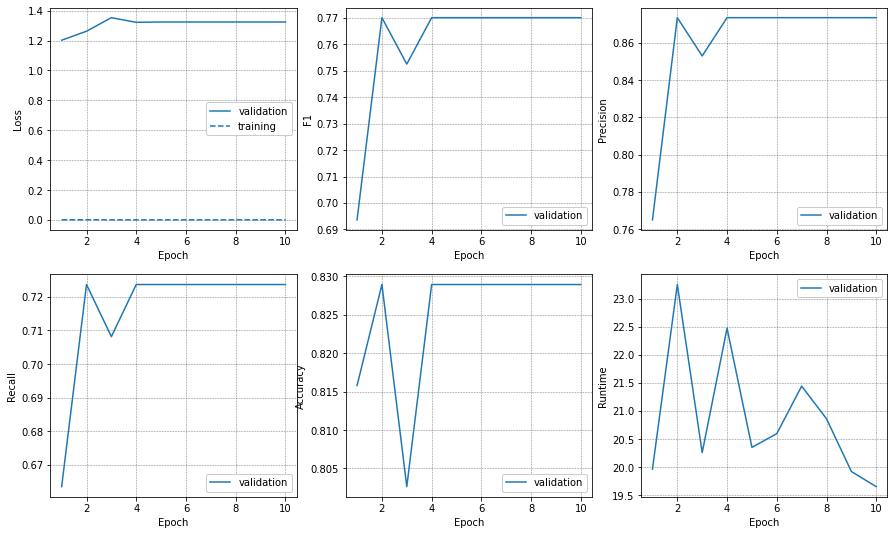

In [44]:
plt.figure(figsize=(15,9))
plt.tight_layout()

metrics = ['eval_loss','eval_f1','eval_precision','eval_recall','eval_accuracy','eval_runtime']

for idx, metric in enumerate(metrics):
    with plt.style.context(['grid']):
        ax = plt.subplot(2,3,idx+1).plot(xlmr_history['epoch'],
                                    xlmr_history[metric],
                                    label='validation')

        #Also plot training loss when plotting validation loss
        if metric == 'eval_loss':
            ax = plt.subplot(2,3,idx+1).plot(xlmr_history['epoch'],
                                             xlmr_history['loss'],
                                             color = ax[0].get_color(),
                                             linestyle= "--",
                                             label='training')



        plt.xlabel('Epoch')
        plt.ylabel(metric.replace('eval_','').capitalize())
        plt.legend()

- Validation loss is really high compared to the trianing loss, suggesting the model is overfitting on the training data. 
- We see improvement on the metrics compared to original pretrained model, although it's not really huge (5% increase) 

#### Validation Results Discussion

We see that the best model is the model from epoch 2 above (checkpoint-58), because of its better performance on the validation loss: 
- **Validation Loss:** 1.262526
- **F1:** 0.770091
- **Precision:** 0.873432
- **Recall:** 0.723658
- **Accuracy:** 0.828947

We load the model and predict on the test to diagnose what areas it is flawed in:

### 6. Test set Prediction with the Fine-tuned Baseline XLMR-roBERTa

In [17]:
#Load the best checkpoint
baseline_xlmr = AutoModelForSequenceClassification.from_pretrained("../models/xlmr-roberta/checkpoint-58")

# Make the test set ready
test_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'test_set' ").Text.tolist(),
    labels = df.query("split_group == 'test_set' ").label.tolist(),
    tokenizer  = tokenizer
)

training_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
)

trainer = Trainer(
    model           = baseline_xlmr,
    args            = training_args,
    compute_metrics = compute_metrics,
)

bxlmr_test_preds = trainer.predict(test_set_dataset)

***** Running Prediction *****
  Num examples = 76
  Batch size = 8


### 7. Evaluating the model: How well does it classify tweets?

In [18]:
pd.DataFrame([bxlmr_test_preds[-1]])

,test_loss,test_f1,test_precision,test_recall,test_accuracy,test_runtime,test_samples_per_second,test_steps_per_second
0,1.596158,0.67707,0.738889,0.653069,0.776316,19.8694,3.825,0.503


In [19]:
y_true = df.query("split_group == 'test_set' ").label.tolist()
bxlmr_preds = np.argmax(bxlmr_test_preds[0], axis=1).flatten()

print(classification_report(y_true, bxlmr_preds))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        44
           1       0.75      0.81      0.78        26
           2       0.67      0.33      0.44         6

    accuracy                           0.78        76
   macro avg       0.74      0.65      0.68        76
weighted avg       0.77      0.78      0.77        76



In [21]:
bxlmr_cm = confusion_matrix(y_true, bxlmr_preds)
bxlmr_disp = ConfusionMatrixDisplay(confusion_matrix=bxlmr_cm, 
                                    display_labels = ['Negative', 'Neutral', 'Positive'])

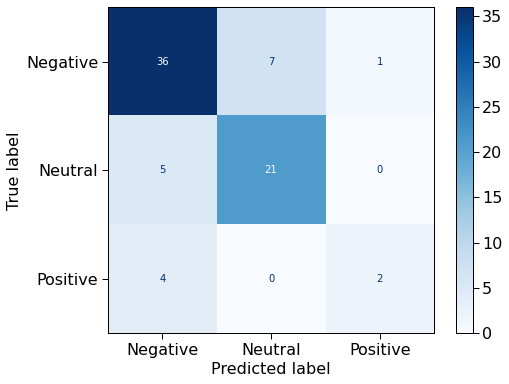

In [22]:
with plt.style.context(['notebook','no-latex']):
    bxlmr_disp.plot(cmap='Blues',ax=None)
    plt.grid(False)
    plt.show()

#### Pros
- Does pretty well identifying negative and neutral predictions
- Fairly well on positive samples

#### Cons
- Over-predicts negative
- Overfits on the training data

---

### 6. XLMR-roBERTa-base
**`Increased batch size` | `Loss function class reweighting`**

**Load the XLMR model and fine-tune using Huggingface Trainer**

**Setup Trainer and train**

In [23]:
class CustomTrainer(Trainer):
    
    """
    Class weighted trainer to account for imbalance
    """
    
    def __init__(self, no_of_classes, samples_per_cls, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = self.get_ens_weights(no_of_classes, samples_per_cls)
        
    def get_ens_weights(self, no_of_classes,samples_per_cls,beta=0.99):
    
        """
        Compute class weights using effective number of samples strategy
        """

        effective_num = 1.0 - np.power(beta, samples_per_cls)
        weights = (1.0 - beta) / np.array(effective_num)
        weights = weights / np.sum(weights) * no_of_classes
        weights = torch.tensor(weights.astype(np.float32))
        
        return weights
    
    def compute_loss(self, model, inputs, return_outputs=False):
        
        labels = inputs.get("labels")
        #Forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        #Compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss(weight= self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#Define the training parameters
lr_training_args = TrainingArguments(
    output_dir                  = "../models/xlmr-roberta/",
    num_train_epochs            = 15,
    seed                        = 22,
    per_device_train_batch_size = 32, #Increase training batch size to ensure that each batch has a decent chance of containing a few positive samples.
    warmup_steps                = 500, #Add warmup steps since this is an entirely new problem domain for this pretrained model
    save_total_limit            = 2,
    load_best_model_at_end      = True,
    metric_for_best_model       = 'f1',    
    save_strategy               = "epoch",
    logging_strategy            = "epoch",
    evaluation_strategy         = "epoch"
)

#Define Trainer object
lr_trainer = CustomTrainer(
    no_of_classes   = len(df.label.unique()),
    samples_per_cls = df.label.value_counts(sort=False).to_list(),
    model           = xlmr_model,
    args            = lr_training_args,
    train_dataset   = train_set_dataset,
    eval_dataset    = val_set_dataset,
    compute_metrics = compute_metrics
)


#Start pre-training!
lr_trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 225
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 120


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,0.611800,0.572164,0.721598,0.726449,0.718920,0.763158
2,0.598700,0.566294,0.709630,0.716518,0.706575,0.750000
3,0.597600,0.562052,0.709630,0.716518,0.706575,0.750000
4,0.589400,0.562147,0.718298,0.728535,0.714327,0.763158
5,0.611200,0.556739,0.718298,0.728535,0.714327,0.763158
6,0.680200,0.552175,0.721598,0.726449,0.718920,0.763158
7,0.414900,0.552034,0.721598,0.726449,0.718920,0.763158
8,0.367300,0.540717,0.737527,0.761449,0.718920,0.763158
9,0.365700,0.534294,0.721598,0.726449,0.718920,0.763158
10,0.271800,0.559085,0.746128,0.772281,0.726672,0.776316


***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/xlmr-roberta/checkpoint-8
Configuration saved in ../models/xlmr-roberta/checkpoint-8/config.json
Model weights saved in ../models/xlmr-roberta/checkpoint-8/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/xlmr-roberta/checkpoint-16
Configuration saved in ../models/xlmr-roberta/checkpoint-16/config.json
Model weights saved in ../models/xlmr-roberta/checkpoint-16/pytorch_model.bin
Deleting older checkpoint [../models/xlmr-roberta/checkpoint-58] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/xlmr-roberta/checkpoint-24
Configuration saved in ../models/xlmr-roberta/checkpoint-24/config.json
Model weights saved in ../models/xlmr-roberta/checkpoint-24/pytorch_model.bin
Deleting older checkpoint [../models/xlmr-roberta/checkpoint-16

TrainOutput(global_step=120, training_loss=0.3881006288031737, metrics={'train_runtime': 5238.2437, 'train_samples_per_second': 0.644, 'train_steps_per_second': 0.023, 'total_flos': 720695115360000.0, 'train_loss': 0.3881006288031737, 'epoch': 15.0})

#### Validation Results Discussion

No real improvement in performance despite increasing batch size and reweighting the loss function. Best model doesn't perform as well as the other approach, although has a much lower validation loss.

### 10. Conclusion

Comparing this to the M-BERT models and BerTweet models, we see that the BerTweet models perform significantly better despite being a monolingual model (i.e. trained on English tweets). This might make sense because pidgin English represents a relatively small proportion of the Nigerian tweets and even the pidgin English tweets involved very light use of pidgin – hence, the tweets closely mirrored English tweets.

Based on this, I choose to continue my modeling efforts with the BerTweet model.